In [49]:
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from tensorflow import keras as k
import numpy as np

In [50]:
crimes = pd.read_csv("crimes_encoded.csv")

In [51]:
crimes.head()

,location_code,estacao,ano,mes,dia,mes_sin,mes_cos,dia_sin,dia_cos,periodo,pontos
0,12658,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108015.0
1,1427,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107531.0
2,1440,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107530.0
3,17021,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108039.0
4,17021,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108039.0


In [52]:
X_date = crimes[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]].values
X_location = crimes["location_code"]
X = {"location_code": X_location, "date_features": X_date}

In [53]:
y = crimes["pontos"]
y = y / y.max()

In [54]:
num_locations = crimes["location_code"].max() + 1
num_locations

37545

In [55]:
k.utils.set_random_seed(42)

In [56]:
location = k.layers.Input(shape=(1,), name="location_code")
date_components = k.layers.Input(shape=(7,), name="date_features")

In [57]:
def embedding_block(input_layer, num_cat, out_dim):
    x = k.layers.Embedding(num_cat, out_dim)(input_layer)
    x = k.layers.Flatten()(x)
    return x

In [58]:
location_embedding = embedding_block(location, num_locations, 200)

In [59]:
normalizer = k.layers.Normalization()
normalizer.adapt(X_date)

In [60]:
time_normalization = normalizer(date_components)
concat_layer = k.layers.concatenate([location_embedding, time_normalization])
hidden_layer = k.layers.Dense(10, activation="relu", name="hidden")(concat_layer)
output_layer = k.layers.Dense(1, activation="sigmoid", name="output")(hidden_layer)

In [61]:
model = k.Model([location, date_components], output_layer)

In [62]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 location_code (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       7509000     ['location_code[0][0]']          
                                                                                                  
 date_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 200)          0           ['embedding_1[0][0]']            
                                                                                            

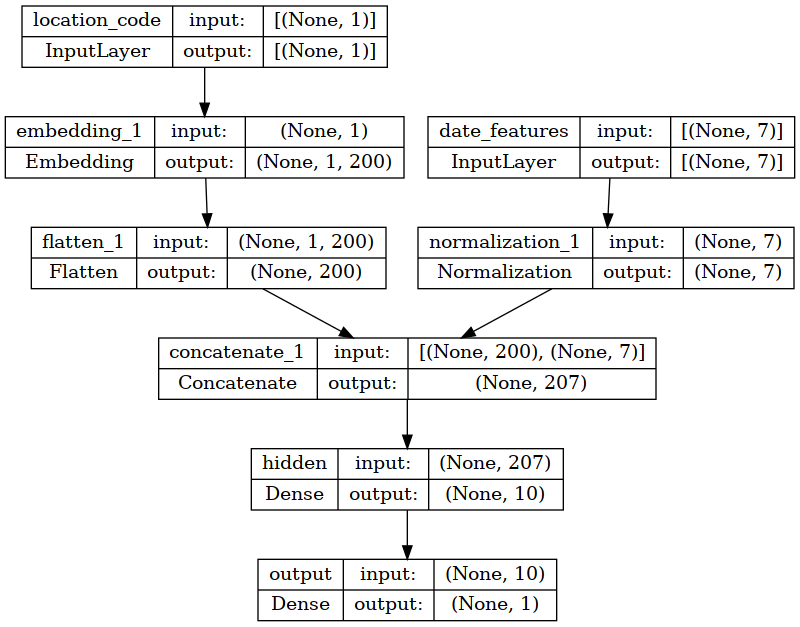

In [63]:
k.utils.plot_model(model, show_shapes=True)

In [64]:
model.compile(optimizer="Adam", loss="mean_absolute_error", metrics=[
    "mean_squared_error",
    "mean_absolute_percentage_error"
    ]
)

In [65]:
model.fit(X, y, batch_size=1_000, epochs=2, validation_split=.2)

Epoch 1/2


99/99 [==============================] - 7s 71ms/step - loss: 0.1904 - mean_squared_error: 0.0531 - mean_absolute_percentage_error: 24.1564 - val_loss: 0.0732 - val_mean_squared_error: 0.0082 - val_mean_absolute_percentage_error: 12.6780
Epoch 2/2
99/99 [==============================] - 7s 66ms/step - loss: 0.0723 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 9.5329 - val_loss: 0.0708 - val_mean_squared_error: 0.0081 - val_mean_absolute_percentage_error: 12.3040


In [66]:
mse, mae, mape = model.evaluate(X, y)
print(f"MSE {mse} | MAE: {mae} | MAPE: {mape}")

3838/3838 [==============================] - 5s 1ms/step - loss: 0.0485 - mean_squared_error: 0.0050 - mean_absolute_percentage_error: 7.1141
MSE 0.04848606511950493 | MAE: 0.004980465397238731 | MAPE: 7.114058494567871


In [67]:
y_pred = model.predict(X)

3838/3838 [==============================] - 5s 1ms/step


(array([  417.,  4475.,  9037., 14509., 20060., 20841., 21167., 17430.,
        10482.,  4390.]),
 array([0.35821676, 0.4207621 , 0.48330742, 0.5458527 , 0.6083981 ,
        0.6709434 , 0.7334887 , 0.79603404, 0.85857934, 0.9211247 ,
        0.98367   ], dtype=float32),
 <BarContainer object of 10 artists>)

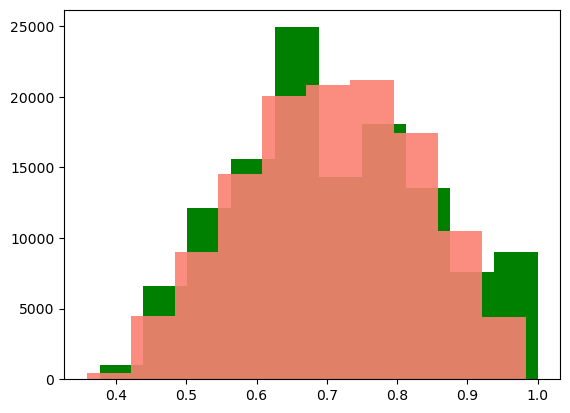

In [68]:
plt.hist(y, color="green")
plt.hist(y_pred, color="salmon", alpha=.9)

In [69]:
crimes["pred"] = y_pred
crimes["score"] = y

<AxesSubplot:xlabel='location_code'>

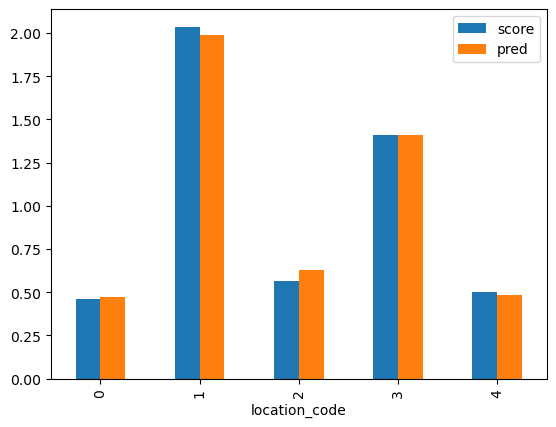

In [70]:
crimes.groupby("location_code")[["score", "pred"]].sum().head().plot(kind="bar")

<AxesSubplot:xlabel='mes'>

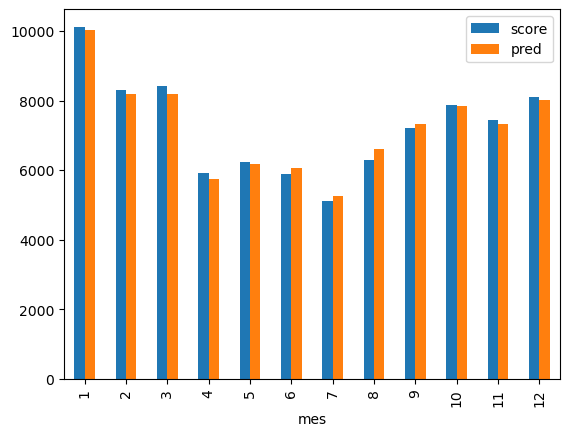

In [71]:
crimes.groupby("mes")[["score", "pred"]].sum().plot(kind="bar")

In [72]:
hidden_dense = model.get_layer("hidden")
kernel, bias = hidden_dense.trainable_weights

In [73]:
kernel.numpy().shape

(207, 10)

(array([6., 1., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([-0.07159033, -0.05020611, -0.02882189, -0.00743767,  0.01394656,
         0.03533078,  0.056715  ,  0.07809923,  0.09948345,  0.12086767,
         0.1422519 ], dtype=float32),
 <BarContainer object of 10 artists>)

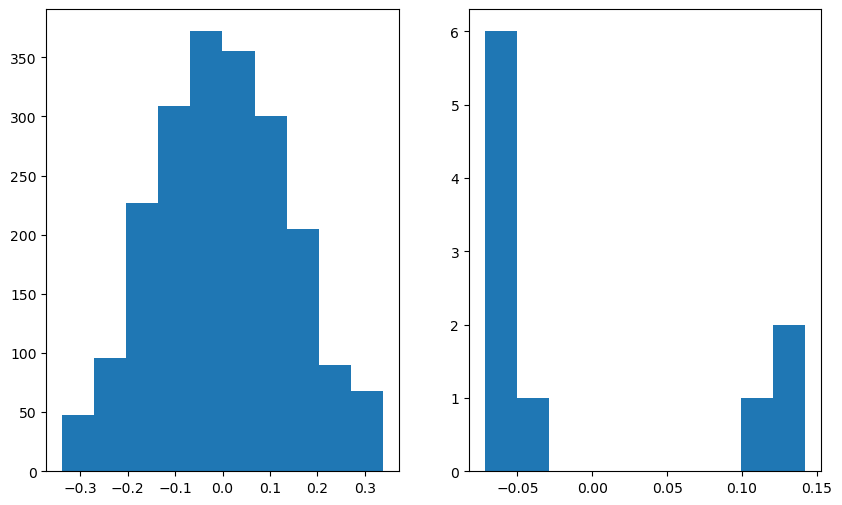

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(kernel.numpy().ravel())
ax2.hist(bias.numpy())

In [75]:
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

In [76]:
obs = {"periodo": 1}
start = date(2023, 4, 1)
obs_lst = []
for i in range(365):
    dt = start + timedelta(days=i)
    aux = {
        "ano": dt.year,
        "mes": dt.month,
        "dia": dt.day,
        "estacao": (dt.month % 12) // 3 + 1,
    }
    obs_lst.append(aux)
obs_lst = pd.DataFrame(obs_lst)
obs_lst.loc[:, "mes_sin"] = sin_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "mes_cos"] = cos_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "dia_sin"] = sin_transform(obs_lst["dia"], 30)
obs_lst.loc[:, "dia_cos"] = cos_transform(obs_lst["dia"], 30)
obs_lst["location_code"] = 1200
obs_lst["periodo"] = 1
obs_lst = {"location_code": obs_lst["location_code"], "date_features": obs_lst[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]]}

In [77]:
forecast_result = model.predict(obs_lst)

12/12 [==============================] - 0s 3ms/step


(array([13., 13., 23., 22., 58., 52., 41., 41., 93.,  9.]),
 array([0.30507967, 0.32627603, 0.3474724 , 0.36866876, 0.38986513,
        0.41106153, 0.4322579 , 0.45345426, 0.47465062, 0.495847  ,
        0.51704335], dtype=float32),
 <BarContainer object of 10 artists>)

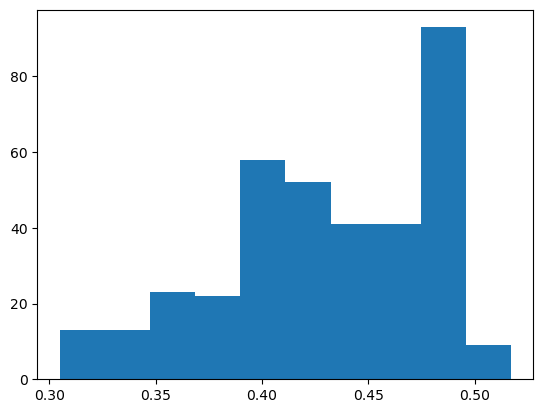

In [78]:
plt.hist(forecast_result)

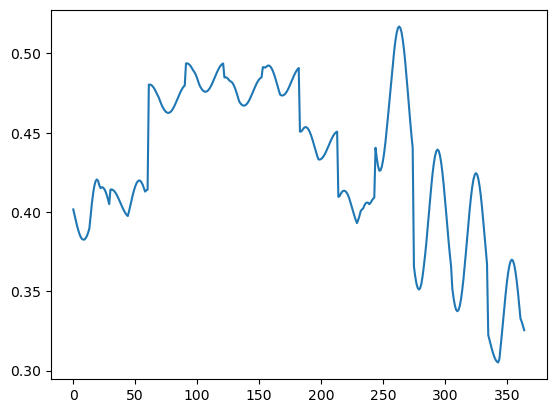

In [79]:
plt.plot(forecast_result)

In [80]:
model.save("../models/score/scoreV2_full")

INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets


INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets
